# Detect Anomalies Using Density Based Clustering


## Clustering-Based Anomaly Detection

- Assumption: Data points that are similar tend to belong to similar groups or clusters, as determined by their distance from local centroids. Normal data points occur around a dense neighborhood and abnormalities are far away.

- Using density based clustering, like DBSCAN, we can design the model such that the data points that do not fall into a cluster are the anomalies.


In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# DBSCAN import
from sklearn.cluster import DBSCAN
# Scaler import
from sklearn.preprocessing import MinMaxScaler


In [2]:
# Import .txt file and convert it to a DataFrame object
df = pd.read_table("anonymized-curriculum-access.txt", sep = '\s', header = None, 
                   names = ['date', 'time', 'page', 'id', 'cohort', 'ip'])


In [3]:
# let's examine the head of the dataframe to make sure its
# what we were expecting
df.head(5)

,date,time,page,id,cohort,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


#### What do we know about this data set?
 - We are examining curriculum access at codeup.com
 - What do we want to find out about this data set?
     - high density page views on certain dates?
     - users that have a high number of page views?
     - cohorts that have unusual activity?

In [4]:
# I know that I have the following columns here:
# id: the number associated with the person viewing the curriculum
# page: the url endpoint associated with the page being visited
# cohort: number associated with the cohort that the id is associated with


Explore

In [5]:
# lets do a little aggregation based on the student id's in the data set,
# focusing on the number of unique hits
id_counts = df.groupby(['id'])['date', 'page', 'cohort'].nunique()

In [6]:
# my index is the user id
# and my aggregated columns represent the unique
# number of days, pages, and cohorts associated with each
id_counts.head()

,date,page,cohort
id,,,
1,637,976,2
2,83,151,1
3,107,169,1
4,54,143,1
5,82,197,1


<AxesSubplot:>

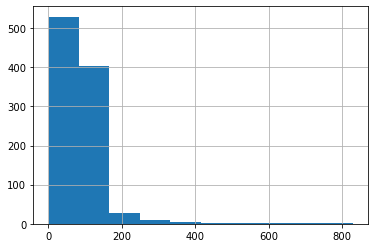

In [7]:
id_counts.date.hist()

In [8]:
# initial questions:
# id #1 is likely a curriculum developer or someone involved on the Codeup side.
# We have some instances near the bottom of a single or < week number of page/day access
# what different values can we associate with mulitple cohort assignments?

In [9]:
# let's observe unique hits based on cohort
cohort_counts = df.groupby('cohort')['id', 'date','page'].nunique()

 - I want to observe the initial visit per user in this data set.
     - How am I going to do this?

In [10]:

# let's go back to our original dataframe and 
# convert to a datetime
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900223 entries, 0 to 900222
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    900223 non-null  object 
 1   time    900223 non-null  object 
 2   page    900222 non-null  object 
 3   id      900223 non-null  int64  
 4   cohort  847330 non-null  float64
 5   ip      900223 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 41.2+ MB


In [11]:
# convert our date to a pandas datetime so we can take the minimum
# value
df['date'] = pd.to_datetime(df['date'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900223 entries, 0 to 900222
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    900223 non-null  datetime64[ns]
 1   time    900223 non-null  object        
 2   page    900222 non-null  object        
 3   id      900223 non-null  int64         
 4   cohort  847330 non-null  float64       
 5   ip      900223 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 41.2+ MB


In [13]:
first_access = df.groupby('id')['date'].min()

In [14]:
first_access

id
1     2018-01-26
2     2018-01-26
3     2018-01-26
4     2018-01-26
5     2018-01-26
         ...    
977   2021-04-12
978   2021-04-12
979   2021-04-12
980   2021-04-13
981   2021-04-19
Name: date, Length: 981, dtype: datetime64[ns]

In [15]:
# can I use this series to examine when cohorts potentially 
# start inside this data set?
# let's use this series to break out that index and then regroup based on
# that first access date per user



In [16]:
# let's utilize that index that exists as the id, pop it back out into 
# a more columnar status, and then proceed forward with observing 
# high volume dates

In [17]:
id_by_first_access_date = pd.DataFrame({'first_access_date': first_access}).reset_index().\
groupby('first_access_date').count()

In [18]:
id_by_first_access_date.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2018-01-26 to 2021-04-19
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      251 non-null    int64
dtypes: int64(1)
memory usage: 3.9 KB


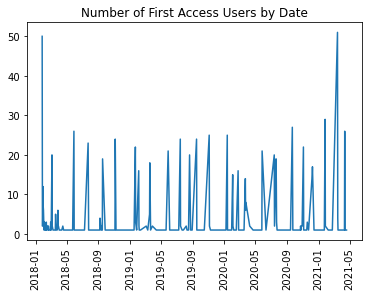

In [19]:
plt.plot(id_by_first_access_date)
plt.xticks(rotation=90)
plt.title('Number of First Access Users by Date')
plt.show()

 - Takeaways:
     - It appears that there is a pretty clear pattern of multiple users starting between strong periods of lag.  It seems that we could determine when cohorts start based on this information and corroborate with any outside information sources to examine if mass curriculum access happened outside of the expectected or anticipated window for said curriculum access

Could someone be stealing the content of our curriculum for their benefit beyond personal education? If so, we would probably see them accessing a large number of unique pages. I would imagine they wouldn't spend much time on each page, maybe taking screen shots, copy/paste or downloading the content. Let's take a look. 

Aggregate and compute 2 features...number of unique pages and total page views. 

In [20]:
# let's make an examination:
# we want to look at individual users,
# and I want to know how they interact with pages in the curriculum,
# the number of unique pages and the number of total pages
page_views = df.groupby(['id'])['page'].agg(['count', 'nunique'])

In [21]:
page_views

,count,nunique
id,,
1,7404,976
2,1541,151
3,1562,169
4,692,143
5,1701,197
...,...,...
977,86,12
978,55,18
979,127,20


<AxesSubplot:>

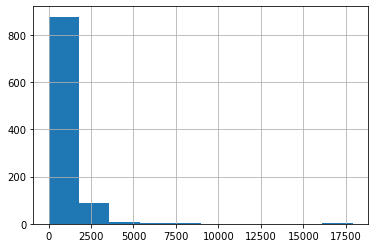

In [22]:
page_views['count'].hist()

In [23]:
# let's narrow down the scope
# if we want to examine the users that have a lower count
# but a high nunique,
# we observed with our value counts and histograms previously
# that we had a range of approxiately 200 for each of those features
# per user
# lets narrow down to users that have less than 200 page view total counts
# but have over 190
page_views[(page_views['count'] < 600) & (page_views['nunique'] > 190)]

,count,nunique
id,,
51,592,194
313,270,194


Scale each attribute linearly. 

In [24]:
# create the scaler
scaler = MinMaxScaler().fit(page_views)
# use the scaler
scaled_page_views = scaler.transform(page_views)

In [25]:
scaled_page_views[0:5]

array([[0.41329835, 1.        ],
       [0.08597588, 0.15384615],
       [0.08714828, 0.17230769],
       [0.03857749, 0.14564103],
       [0.09490844, 0.20102564]])

In [26]:
# whip up some new column names
scaled_cols = [col + '_scaled' for col in page_views.columns]

In [27]:
scaled_cols

['count_scaled', 'nunique_scaled']

In [28]:
scaled_page_views_df = pd.DataFrame(scaled_page_views, columns=scaled_cols, index=page_views.index)

Construct a DBSCAN object that requires a minimum of 20 data points in a neighborhood of radius 0.1 to be considered a core point.

In [29]:
# create the object first
dbsc = DBSCAN(min_samples=20, eps=0.1)

In [30]:
dbsc

DBSCAN(eps=0.1, min_samples=20)

In [31]:
# fit the object like we normally would with sklearn
dbsc.fit(scaled_page_views_df)

DBSCAN(eps=0.1, min_samples=20)

In [57]:
dbsc.labels_.shape

(981,)

In [33]:
scaled_page_views_df.shape

(981, 2)

In [34]:
page_views.head(2)

,count,nunique
id,,
1,7404,976
2,1541,151


In [35]:
scaled_page_views_df.head(2)

,count_scaled,nunique_scaled
id,,
1,0.413298,1.000000
2,0.085976,0.153846


In [36]:
# Merge the scaled and non-scaled values into one dataframe
page_views_total = page_views.merge(
    scaled_page_views_df, on=page_views.index).drop(
    columns=['key_0'])

In [37]:
# sanity check for the shape of the df:
page_views_total.shape

(981, 4)

In [38]:
# let's apply the dbscan labels

In [39]:
page_views_total['labels'] = dbsc.labels_

In [49]:
page_views_total.labels.value_counts()

 0    973
-1      8
Name: labels, dtype: int64

In [40]:
page_views_total[page_views_total.labels == -1]

,count,nunique,count_scaled,nunique_scaled,labels
0,7404,976,0.413298,1.000000,-1
10,17913,871,1.000000,0.892308,-1
52,12329,333,0.688254,0.340513,-1
63,16347,437,0.912573,0.447179,-1
247,5075,625,0.283274,0.640000,-1
313,7783,225,0.434457,0.229744,-1
494,6451,243,0.360094,0.248205,-1
580,6434,354,0.359145,0.362051,-1


In [41]:
page_views = page_views_total

In [42]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(page_views.describe())
print("-------------")
print("Inliers")
print(page_views[page_views.labels==0].describe())
print("-------------")
print("Outliers")
print(page_views[page_views.labels==-1].describe())

Population
              count     nunique  count_scaled  nunique_scaled      labels
count    981.000000  981.000000    981.000000      981.000000  981.000000
mean     917.657492  118.356779      0.051176        0.120366   -0.008155
std     1208.871322   80.781117      0.067489        0.082852    0.089982
min        1.000000    1.000000      0.000000        0.000000   -1.000000
25%      187.000000   53.000000      0.010384        0.053333    0.000000
50%      692.000000  140.000000      0.038577        0.142564    0.000000
75%     1297.000000  166.000000      0.072354        0.169231    0.000000
max    17913.000000  976.000000      1.000000        1.000000    0.000000
-------------
Inliers
             count     nunique  count_scaled  nunique_scaled  labels
count   973.000000  973.000000    973.000000      973.000000   973.0
mean    843.253854  115.153135      0.047022        0.117080     0.0
std     787.044042   68.765856      0.043939        0.070529     0.0
min       1.000000    1.0

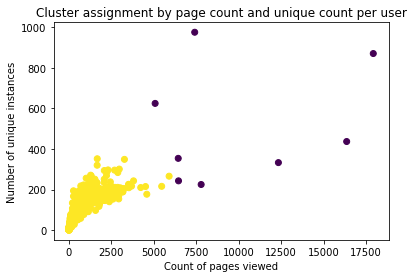

In [53]:
plt.scatter(page_views['count'],
           page_views['nunique'],
           c=page_views['labels'])
plt.xlabel('Count of pages viewed')
plt.ylabel('Number of unique instances')
plt.title('Cluster assignment by page count and unique count per user')
plt.show()

### Follow up questions:
    - These unusual users dont seem to all be weird in the same way.
    - What's different about these users specifically?
    - Examine each user based on these parameters,
    - See which url endpoints they are visiting
    - Examine the cohorts those users are associated with
    - Examine the dates associated with first access for those users
    - Determine if these users may be employees, instructors, students that belonged to one or more cohorts, students that went through both programs, etc
    

## Experiment with the DBSCAN properties
- Read up on the epsilon and min_samples arguments into DBSCAN at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
- Experiment with altering the epsilon values (the `eps` argument holding the threshhold parameter). Run the models and visualize the results. What has changed? Why do you think that is?
- Double the `min_samples` parameter. Run your model and visualize the results. Consider what changed and why.

# Exercise

**file name:** clustering_anomaly_detection.py or clustering_anomaly_detection.ipynb


### Clustering - DBSCAN

Ideas: 

Use DBSCAN to detect anomalies in curriculumn access. 

Use DBSCAN to detect anomalies in other products from the customers dataset. 

Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).
